## Premise

Generate a dataset that follows a simple system of ODEs using interative calculations. Then train a neural network to fit the dataset

##### System of ODE:

${dy_1\over dx} = y_1,$

${dy_2\over dx}=y_1-y_2,$

with initial conditions of form $y_1(0)=1$ and $y_2(0)=2$

## Neural Network Model

Implemented using Pytorch Lightning model. I'm lazy and do not want to manually implement training and epoch loops :3.

In [2]:
import torch, torch.nn as nn, torch.utils.data as data, torchvision as tv, torch.nn.functional as F
import lightning as L
import numpy as np

class Learner(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 20),
            nn.ELU(),
            nn.Linear(20, 50),
            nn.ELU(),
            nn.Linear(50, 50),
            nn.ELU(),
            nn.Linear(50, 2)
        )

    def forward(self, input):
        return self.model(input);

    def training_step(self, batch, batch_idx):
        '''
        Given x, given y = y1, y2
        '''
        x_data, y_data = batch
        y_predicted = self.model(x_data)
        
        loss = nn.MSELoss()(y_data, y_predicted)
        
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=.0005)
        return optimizer

## Dataset Generation

Implemented using torch.data.Dataset. The data is generated by iteratively generating the function by calculating small increments of dx and dy.

In [3]:
class Dataset(data.Dataset):

    def __init__(self, init, end, n, initial_condition):
        self.n = n
        self.x = torch.linspace(init, end, self.n)
        self.y = initial_condition.unsqueeze(0)
        
        dx = (end - init) / self.n
        for i in range(self.n - 1):
            dy = torch.Tensor([self.y[-1][0], self.y[-1][0] - self.y[-1][1]]) * dx
            new_y = self.y[-1] + dy
            self.y = torch.cat((self.y, new_y.unsqueeze(0)), 0)
    
    def __len__(self):

        return self.n

    def __getitem__(self, idx):
        x = self.x[idx, np.newaxis]
        y = self.y[idx]

        return torch.Tensor(x), torch.Tensor(y)

In [4]:
initial_condition = torch.Tensor([1, 2])
train = Dataset(0, 10, 10000, initial_condition)

Real solution from solving it analytically

In [5]:
def y_1_analytical(x):
    return torch.exp(x)

def y_2_analytical(x):
    return 0.5 * torch.exp(x) + 1.5 * torch.exp(-x)

As you can see, the analytical and generate solution are almost the same

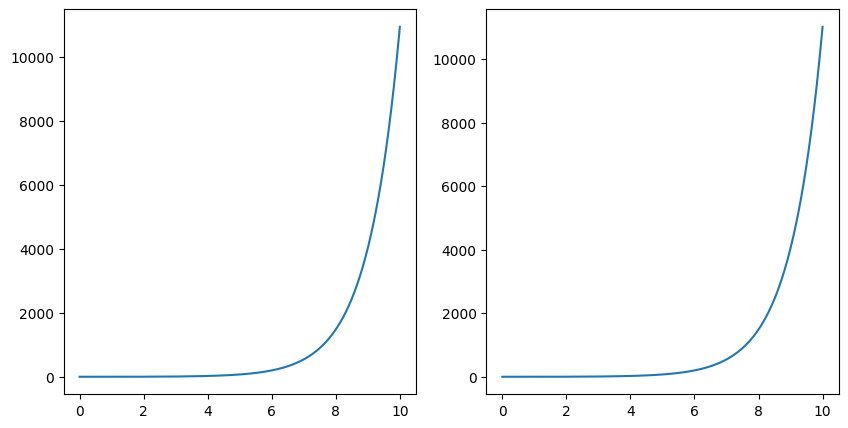

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))
ax_dataset = fig.add_subplot(121)
ax_dataset.plot(train.x[:], train.y[:, 1])

ax_analytical = fig.add_subplot(122)
ax_analytical.plot(torch.linspace(0, 10, 10000), y_2_analytical(torch.linspace(0, 10, 10000)))

## Training

In [7]:
print(torch.version.cuda)

None


In [10]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

early_stop_callback = EarlyStopping(monitor="train_loss", min_delta=0.00, patience=50, verbose=False, mode="min", stopping_threshold=0.1)

trainer = L.Trainer(accelerator="auto", logger=False, max_epochs=10000, callbacks=[early_stop_callback])
learner = Learner()
trainer.fit(learner, data.DataLoader(train, batch_size=100))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 3.7 K 
-------------------------------------
3.7 K     Trainable params
0         Non-trainable params
3.7 K     Total params
0.015     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

## Evaluating Predictions

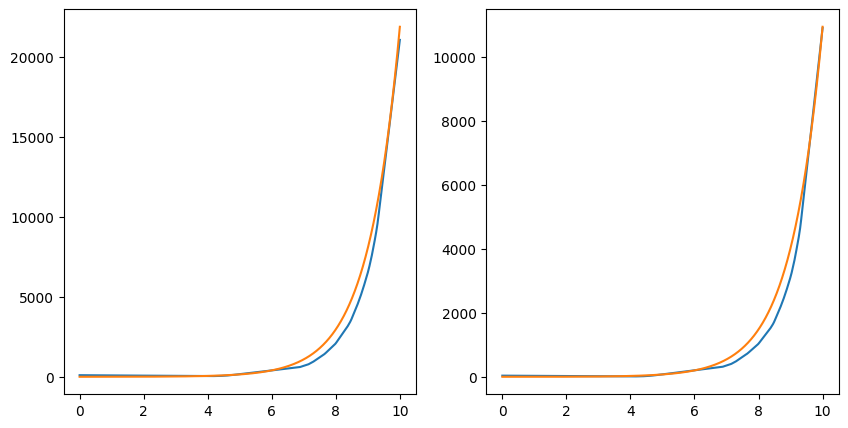

In [177]:
y_hat = learner.model.forward(train.x.view(10000, 1))
y_hat = y_hat.detach().cpu()

fig = plt.figure(figsize=(10,5))
ax_y1 = fig.add_subplot(121)
ax_y1.plot(train.x[:], y_hat[:, 0])
ax_y1.plot(train.x[:], train.y[:, 0])

ax_y2 = fig.add_subplot(122)
ax_y2.plot(train.x[:], y_hat[:, 1])
ax_y2.plot(train.x[:], train.y[:, 1])

That's surprising. The loss function wasn't converging yet the resulting graphs are pretty similar to the real functions. The loss was also pretty large...wut dis dont make no sense. :|